In [6]:
import pandas as pd
import numpy as np
import time
import hdbscan

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from sklearn import metrics
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

/home/abhi/Desktop/scikit-learn/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
def get_centermost_point(cluster):
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

In [8]:

    
def optics_local(df):
    coords = df.as_matrix(columns=['LAT', 'LON'])
    start_time = time.time()

    model = OPTICS(min_samples=10, rejection_ratio=0.5)
    db = model.fit_predict(np.radians(coords))
    print("calinski_harabaz score: ",metrics.calinski_harabaz_score(df, model.labels_))
    cluster_labels = model.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    df = df[['LAT', 'LON']]

    df['Cluster'] = db
    cluster_count = df.groupby('Cluster').count().sort_values(by=['LAT'],ascending=False)[:10]
    cluster_count = cluster_count.drop(['LON'],axis=1)
    #x = cluster_count.LAT.keys()

    #print(df['Cluster'].unique())
    #centermost_points = clusters.map(get_centermost_point)
    rep = pd.DataFrame(columns=['LON', 'LAT', 'Count']);
    #print(clusters[0])
    for i in clusters[:len(clusters)-1]:
        length = len(i)
        x =  get_centermost_point(i)
        #print(x)
        rep = rep.append({'LON':x[1], 'LAT': x[0], 'Count':length},ignore_index=True)
    #print(rep)
    rs = rep
    #print(rs)
    rep = rep.sort_values(by='Count', ascending=False)[:10]
    
    fig, ax = plt.subplots(figsize=[10, 6])
    rs_scatter = ax.scatter(rs['LON'], rs['LAT'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
    df_scatter = ax.scatter(df['LON'], df['LAT'], c='k', alpha=0.9, s=3)
    ax.set_title('Full data set vs OPTICS reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()
    print(" --- OPTICS --- %s seconds ---" % round(time.time() - start_time))
    #return rep



In [16]:
def dbscan_local(df):
    start_time = time.time()
    coords = df.as_matrix(columns=['LAT', 'LON'])
    kms_per_radian = 6371.0088
    epsilon = 1.2 / kms_per_radian

    model = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')
    
    db = model.fit_predict(np.radians(coords))
    print("calinski_harabaz score: ",metrics.calinski_harabaz_score(df, model.labels_))
    
    #print("Silhouette_score: ",metrics.silhouette_score(df, model.labels_, metric='pairwise distances'))
    
    cluster_labels = model.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    
    df['Cluster'] = db
    #cluster_count = df.groupby('Cluster').count().sort_values(by=['LAT'],ascending=False)[:10]
    #cluster_count = cluster_count.drop(['LON'],axis=1)
    
    rep = pd.DataFrame(columns=['LON', 'LAT', 'Count']);

    for i in clusters[:len(clusters)-1]:
        length = len(i)
        x =  get_centermost_point(i)
        #print(x)
        rep = rep.append({'LON':x[1], 'LAT': x[0], 'Count':length},ignore_index=True)
    #print(rep)
    rs = rep
    rep = rep.sort_values(by='Count', ascending=False)[:10]
    
#     centermost_points = clusters.map(get_centermost_point)
#     lats, lons = zip(*centermost_points)
#     rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
    
#     rs = rep_points.apply(lambda row: df[(df['LAT']==row['lat']) & (df['LON']==row['lon'])].iloc[0], axis=1)
#     j = 0
#     rs['count'] = cluster_count.LAT
    # for i in cluster_count.LAT:
    #     print(i)
    #     j+=1
    #rs.dropna(axis=0)
    
    
    fig, ax = plt.subplots(figsize=[10, 6])
    rs_scatter = ax.scatter(rs['LON'], rs['LAT'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
    df_scatter = ax.scatter(df['LON'], df['LAT'], c='k', alpha=0.9, s=3)
    ax.set_title('Full data set vs DBSCAN reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()

    print(" --- DBSCAN --- %s seconds ---" % round(time.time() - start_time))

  

In [17]:
def hdbscan_local(df):
    start_time = time.time()
    X = np.array(df)
    X= X.astype(np.float)
    rads = np.radians(X)

    kms_per_radian = 6371.0088
    epsilon = 1.2 / kms_per_radian
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
    cluster_labels = clusterer.fit_predict(df)
    print("calinski_harabaz score: ",metrics.calinski_harabaz_score(df, cluster_labels))
    df['Cluster']=cluster_labels

    cluster_count = df.groupby('Cluster').count().sort_values(by=['LAT'],ascending=False)[:10]
    cluster_count = cluster_count.drop(['LON'],axis=1)
    
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([rads[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    #x = np.ndarray()
    rep = pd.DataFrame(columns=['LON', 'LAT', 'Count']);
        #print(clusters[0])
    for i in clusters[:len(clusters)-1]:
        length = len(i)
        x =  get_centermost_point(i)
        #print(x)
        rep = rep.append({'LON':x[1], 'LAT': x[0], 'Count':length},ignore_index=True)
    #print(rep)
    rs = rep
    rs = np.degrees(rs)
    rep = rep.sort_values(by='Count', ascending=False)[:10]
    
    fig, ax = plt.subplots(figsize=[10, 6])
    rs_scatter = ax.scatter(rs['LON'], rs['LAT'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
    df_scatter = ax.scatter(df['LON'], df['LAT'], c='k', alpha=0.9, s=3)
    ax.set_title('Full data set vs HDBSCAN reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()

    print(" --- HDBSCAN --- %s seconds ---" % round(time.time() - start_time))
    #return rep


In [40]:
import pylab as pl
def kmeans_local(df):
    
#     sse = {}
#     for k in range(1, 10):
#         kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
#         df["clusters"] = kmeans.labels_
#         #print(data["clusters"])
#         sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
#     plt.figure()
#     plt.plot(list(sse.keys()), list(sse.values()))
#     plt.xlabel("Number of cluster")
#     plt.ylabel("SSE")
#     plt.show()
    
    start_time = time.time()
    model= KMeans(n_clusters=10)
    
    Kmeans2 = model.fit_predict(df)
    #print("Calinski_harabaz_score: ",metrics.calinski_harabaz_score(df, Kmeans2))
    #print("Silhouette_score: ",metrics.silhouette_score(df, Kmeans2, metric='euclidean'))
    
    df['Cluster'] = Kmeans2
    cluster_count = df.groupby('Cluster').count().sort_values(by=['LAT'],ascending=False)[:10]
    cluster_count = cluster_count.drop(['LON'],axis=1)
    #x = cluster_count.LAT.keys()
    rep = pd.DataFrame(data={'LON':df['LON'], 'LAT':df['LAT'], 'Count':Kmeans2});
    print(cluster_count)
    print(model.cluster_centers_)
    #pl.figure('K-Means Clustering')
    #pl.scatter(df['LON'],df['LAT'], c = model.labels_)
    #pl.xlabel('Longitude')
    ##pl.ylabel('Latitude')
    #pl.title('K-Means')
    #pl.show()
    
    print(" --- KMEANS --- ",time.time() - start_time," seconds ---" )


In [41]:
import warnings
warnings.simplefilter('ignore')

address_url = "dataset/hi.csv"
address = pd.read_csv(address_url)
print(len(address))
df = address
df = df.drop(['NUMBER','STREET', 'UNIT','CITY', 'DISTRICT', 'REGION', 'POSTCODE', 'ID', 'HASH'], axis=1)
ad_df = df[['LAT', 'LON']]

274328


calinski_harabaz score:  292.78608748303884
Number of clusters: 79


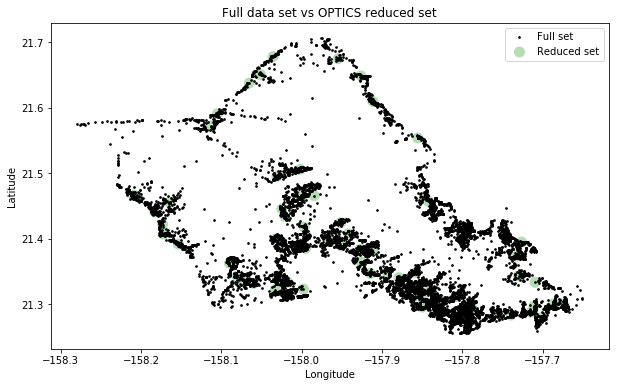

 --- OPTICS --- 26 seconds ---


In [21]:
optics_local(ad_df)
#coords = df.as_matrix(columns=['LAT', 'LON'])

calinski_harabaz score:  106.60602586599367
Number of clusters: 204


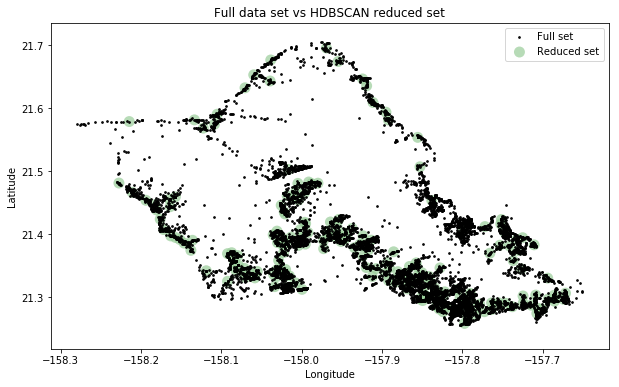

 --- HDBSCAN --- 11 seconds ---


In [22]:
hdbscan_local(ad_df)

calinski_harabaz score:  267.84415358427503
Number of clusters: 7


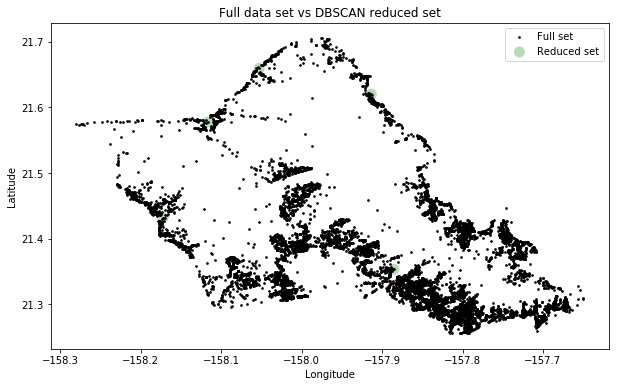

 --- DBSCAN --- 5 seconds ---


In [23]:
dbscan_local(ad_df)

In [42]:
kmeans_local(ad_df)

           LAT
Cluster       
4        62503
9        62035
0        41121
3        22173
2        21466
1        17951
5        15194
7        15117
6        10681
8         6087
[[  21.37377149 -157.75385816]
 [  22.08495264 -159.37698988]
 [  20.83927586 -156.47465181]
 [  21.53963327 -158.00982332]
 [  21.30695465 -157.82753646]
 [  20.82643708 -156.2861905 ]
 [  21.92755484 -159.56020689]
 [  21.4140857  -158.15685899]
 [  20.92083572 -156.66133798]
 [  21.38006222 -157.99524957]]
 --- KMEANS ---  7.160110950469971  seconds ---
